In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from math import ceil
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# tf.config.list_physical_devices('GPU')

Num GPUs Available:  0


In [4]:
# Best parameters: {'batch_size': 64, 'image_size': 128, 'optimizer': 'sgd', 'epochs': 5}
batch_size = 64
img_height = 128
img_width = 128
DATA_DIR = "../chest_Xray/"
TEST = "test/"
TRAIN = "train/"
VAL = "val/"
NORMAL = "NORMAL"
PNEUMONIA = "PNEUMONIA"
NET = "NET"

In [5]:
# Créer un ensemble de données

train_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR +  TRAIN,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode="grayscale",
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  DATA_DIR + VAL,
  validation_split=0.2,
  subset="validation",
  color_mode="grayscale",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 17 files belonging to 2 classes.
Using 3 files for validation.


In [6]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['NORMAL', 'PNEUMONIA']


In [7]:
# Configurer l'ensemble de données pour les performances

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
# Standardiser les données

normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0042356006 0.9988435


In [9]:
# Augmentation des données

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [10]:
# cree le modele

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [11]:
# Compiler le modèle

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
# Résumé du modèle

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)       

In [13]:
# Create a callback allowing to save the best performing model
checkpoint = ModelCheckpoint("saved_model.model.h5", monitor='val_loss', verbose=1, save_best_only=True, min_delta = .002)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10)

In [15]:
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                          patience=10)

In [16]:
# Former le modèle
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint]
)

Epoch 1/5
66/66 [==============================] - ETA: 0s - loss: 5.2226 - accuracy: 0.7335
Epoch 1: val_loss improved from inf to 0.55439, saving model to saved_model.model.h5
66/66 [==============================] - 15s 208ms/step - loss: 5.2226 - accuracy: 0.7335 - val_loss: 0.5544 - val_accuracy: 0.6667
Epoch 2/5
66/66 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.8953
Epoch 2: val_loss improved from 0.55439 to 0.14914, saving model to saved_model.model.h5
66/66 [==============================] - 13s 201ms/step - loss: 0.2554 - accuracy: 0.8953 - val_loss: 0.1491 - val_accuracy: 1.0000
Epoch 3/5
66/66 [==============================] - ETA: 0s - loss: 0.2142 - accuracy: 0.9133
Epoch 3: val_loss did not improve from 0.14914
66/66 [==============================] - 14s 209ms/step - loss: 0.2142 - accuracy: 0.9133 - val_loss: 0.3789 - val_accuracy: 0.6667
Epoch 4/5
66/66 [==============================] - ETA: 0s - loss: 0.1839 - accuracy: 0.9269
Epoch 4: va

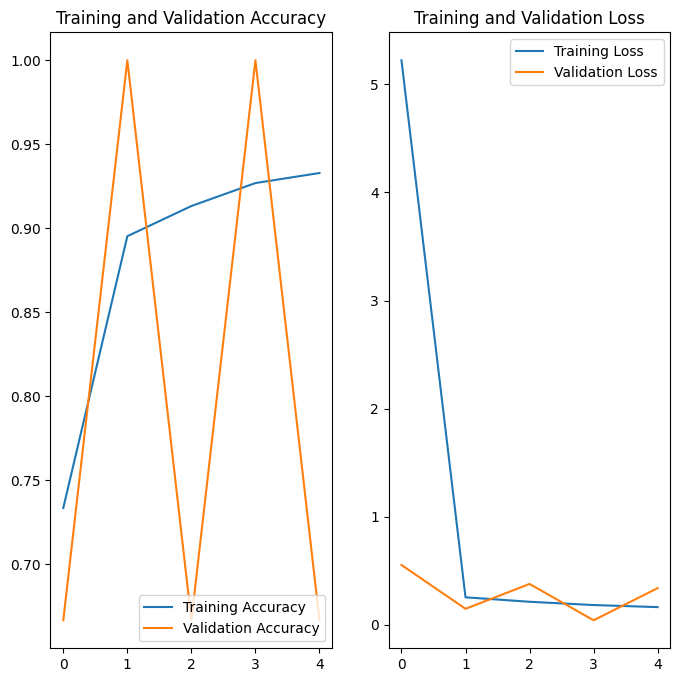

In [17]:
# Visualisez les résultats de l'entraînement

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# test 
import os
  
  
for file in os.listdir(DATA_DIR + VAL + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
  
for file in os.listdir(DATA_DIR + VAL + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + VAL + "/" + NORMAL + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 98.89 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to PNEUMONIA with a 97.93 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with a 98.31 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to PNEUMONIA with a 70.74 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to NORMAL with a 53.09 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to PNEUMONIA with a 99.73 percent confidence.
1/1 [==============================] - 0s 14ms/step
This image most likely belongs to PNEUMONIA with a 94.42 percent confidence.
1/1 [==============================] - 0s 15ms/step
This image most likely belongs to PNEUMONIA with

In [22]:
from sklearn.metrics import confusion_matrix

val_images = []
val_labels = []
pred_labels = []

for file in os.listdir(DATA_DIR + TEST + "/" + PNEUMONIA):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + PNEUMONIA + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(1)  # pneumonia
  pred_labels.append(np.argmax(score))

for file in os.listdir(DATA_DIR + TEST + "/" + NORMAL):
  img = tf.keras.utils.load_img(
      DATA_DIR + TEST + "/" + NORMAL + "/" +file, target_size=(img_height, img_width), color_mode="grayscale"
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  val_images.append(file)
  val_labels.append(0)  # normal
  pred_labels.append(np.argmax(score))

conf_mat = confusion_matrix(val_labels, pred_labels)
print(conf_mat)

UnimplementedError: Graph execution error:

Detected at node 'sequential_1/conv2d/Relu' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Python311\Lib\asyncio\base_events.py", line 604, in run_forever
      self._run_once()
    File "C:\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Python311\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nujab\AppData\Local\Temp\ipykernel_13236\2866584927.py", line 27, in <module>
      predictions = model.predict(img_array)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 2382, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function
      return step_function(self, iterator)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 2155, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 2143, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
      return self(x, training=False)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\engine\base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\nujab\Developement\epitech\Zoidbergb\zoidberg_env\Lib\site-packages\keras\backend.py", line 5396, in relu
      x = tf.nn.relu(x)
Node: 'sequential_1/conv2d/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node sequential_1/conv2d/Relu}}]] [Op:__inference_predict_function_5393]

In [ ]:
# Get the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.title('Confusion matrix')
plt.xticks(range(2), ['Normal','Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal','Pneumonia'], fontsize=10)

plt.show()